# Propagate 5D errors into Action space

In [34]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from scipy.stats import norm
from scipy.linalg import eigh, cholesky

In [35]:
galah_gaia = pyfits.getdata('../input/sobject_iraf_53_2MASS_GaiaDR2_WISE_PanSTARRSDR1_BailerJones_K2seis.fits',1)

In [58]:
def sample_6d_uncertainty(galah_gaia, n_sample=10000, no_correlation = False, extreme_covariance = False):
    np.random.seed(135)
    
    # Mean vector and covariance matrix
    mu = np.array([galah_gaia['ra'] ,galah_gaia['dec'] ,galah_gaia['parallax'], galah_gaia['pmra'], galah_gaia['pmdec'], galah_gaia['rv_guess']])
                           
    s00 = (galah_gaia['ra_error']/(1000.*3600.))**2
    s11 = (galah_gaia['dec_error']/(1000.*3600.))**2
    s22 = galah_gaia['parallax_error']**2
    s33 = galah_gaia['pmra_error']**2
    s44 = galah_gaia['pmdec_error']**2
    s55 = galah_gaia['e_rv_guess']**2
    
    s01 = (galah_gaia['ra_error']/(1000.*3600.)) * (galah_gaia['dec_error']/(1000.*3600.)) * galah_gaia['ra_dec_corr']
    s02 = (galah_gaia['ra_error']/(1000.*3600.)) * galah_gaia['parallax_error'] * galah_gaia['ra_parallax_corr']
    s03 = (galah_gaia['ra_error']/(1000.*3600.)) * galah_gaia['pmra_error'] * galah_gaia['ra_pmra_corr']
    s04 = (galah_gaia['ra_error']/(1000.*3600.)) * galah_gaia['pmdec_error'] * galah_gaia['ra_pmdec_corr']
    s05 = 0

    s12 = (galah_gaia['dec_error']/(1000.*3600.)) * galah_gaia['parallax_error'] * galah_gaia['dec_parallax_corr']
    s13 = (galah_gaia['dec_error']/(1000.*3600.)) * galah_gaia['pmra_error'] * galah_gaia['dec_pmra_corr']
    s14 = (galah_gaia['dec_error']/(1000.*3600.)) * galah_gaia['pmdec_error'] * galah_gaia['dec_pmdec_corr']
    s15 = 0

    s23 = galah_gaia['parallax_error'] * galah_gaia['pmra_error'] * galah_gaia['parallax_pmra_corr']
    s24 = galah_gaia['parallax_error'] * galah_gaia['pmdec_error'] * galah_gaia['parallax_pmdec_corr']
    s25 = 0

    s34 = galah_gaia['pmra_error'] * galah_gaia['pmdec_error'] * galah_gaia['pmra_pmdec_corr']
    s35 = 0

    s45 = 0

    sigma = np.array([
        [s00, s01, s02, s03, s04, s05],
        [s01, s11, s12, s13, s14, s15],
        [s02, s12, s22, s23, s24, s25],
        [s03, s13, s23, s33, s34, s35],
        [s04, s14, s24, s34, s44, s45],
        [s05, s15, s25, s35, s45, s55]
    ])

    sample = np.random.multivariate_normal(mu, sigma, size= n_sample)

    ra       = sample[:,0]
    dec      = sample[:,1]
    parallax = sample[:,2]
    pmra     = sample[:,3]
    pmdec    = sample[:,4]
    rv       = sample[:,5]

    return(ra, dec, parallax, pmra, pmdec, rv)
uncertainty_6d = sample_6d_uncertainty(galah_gaia[17220-1])

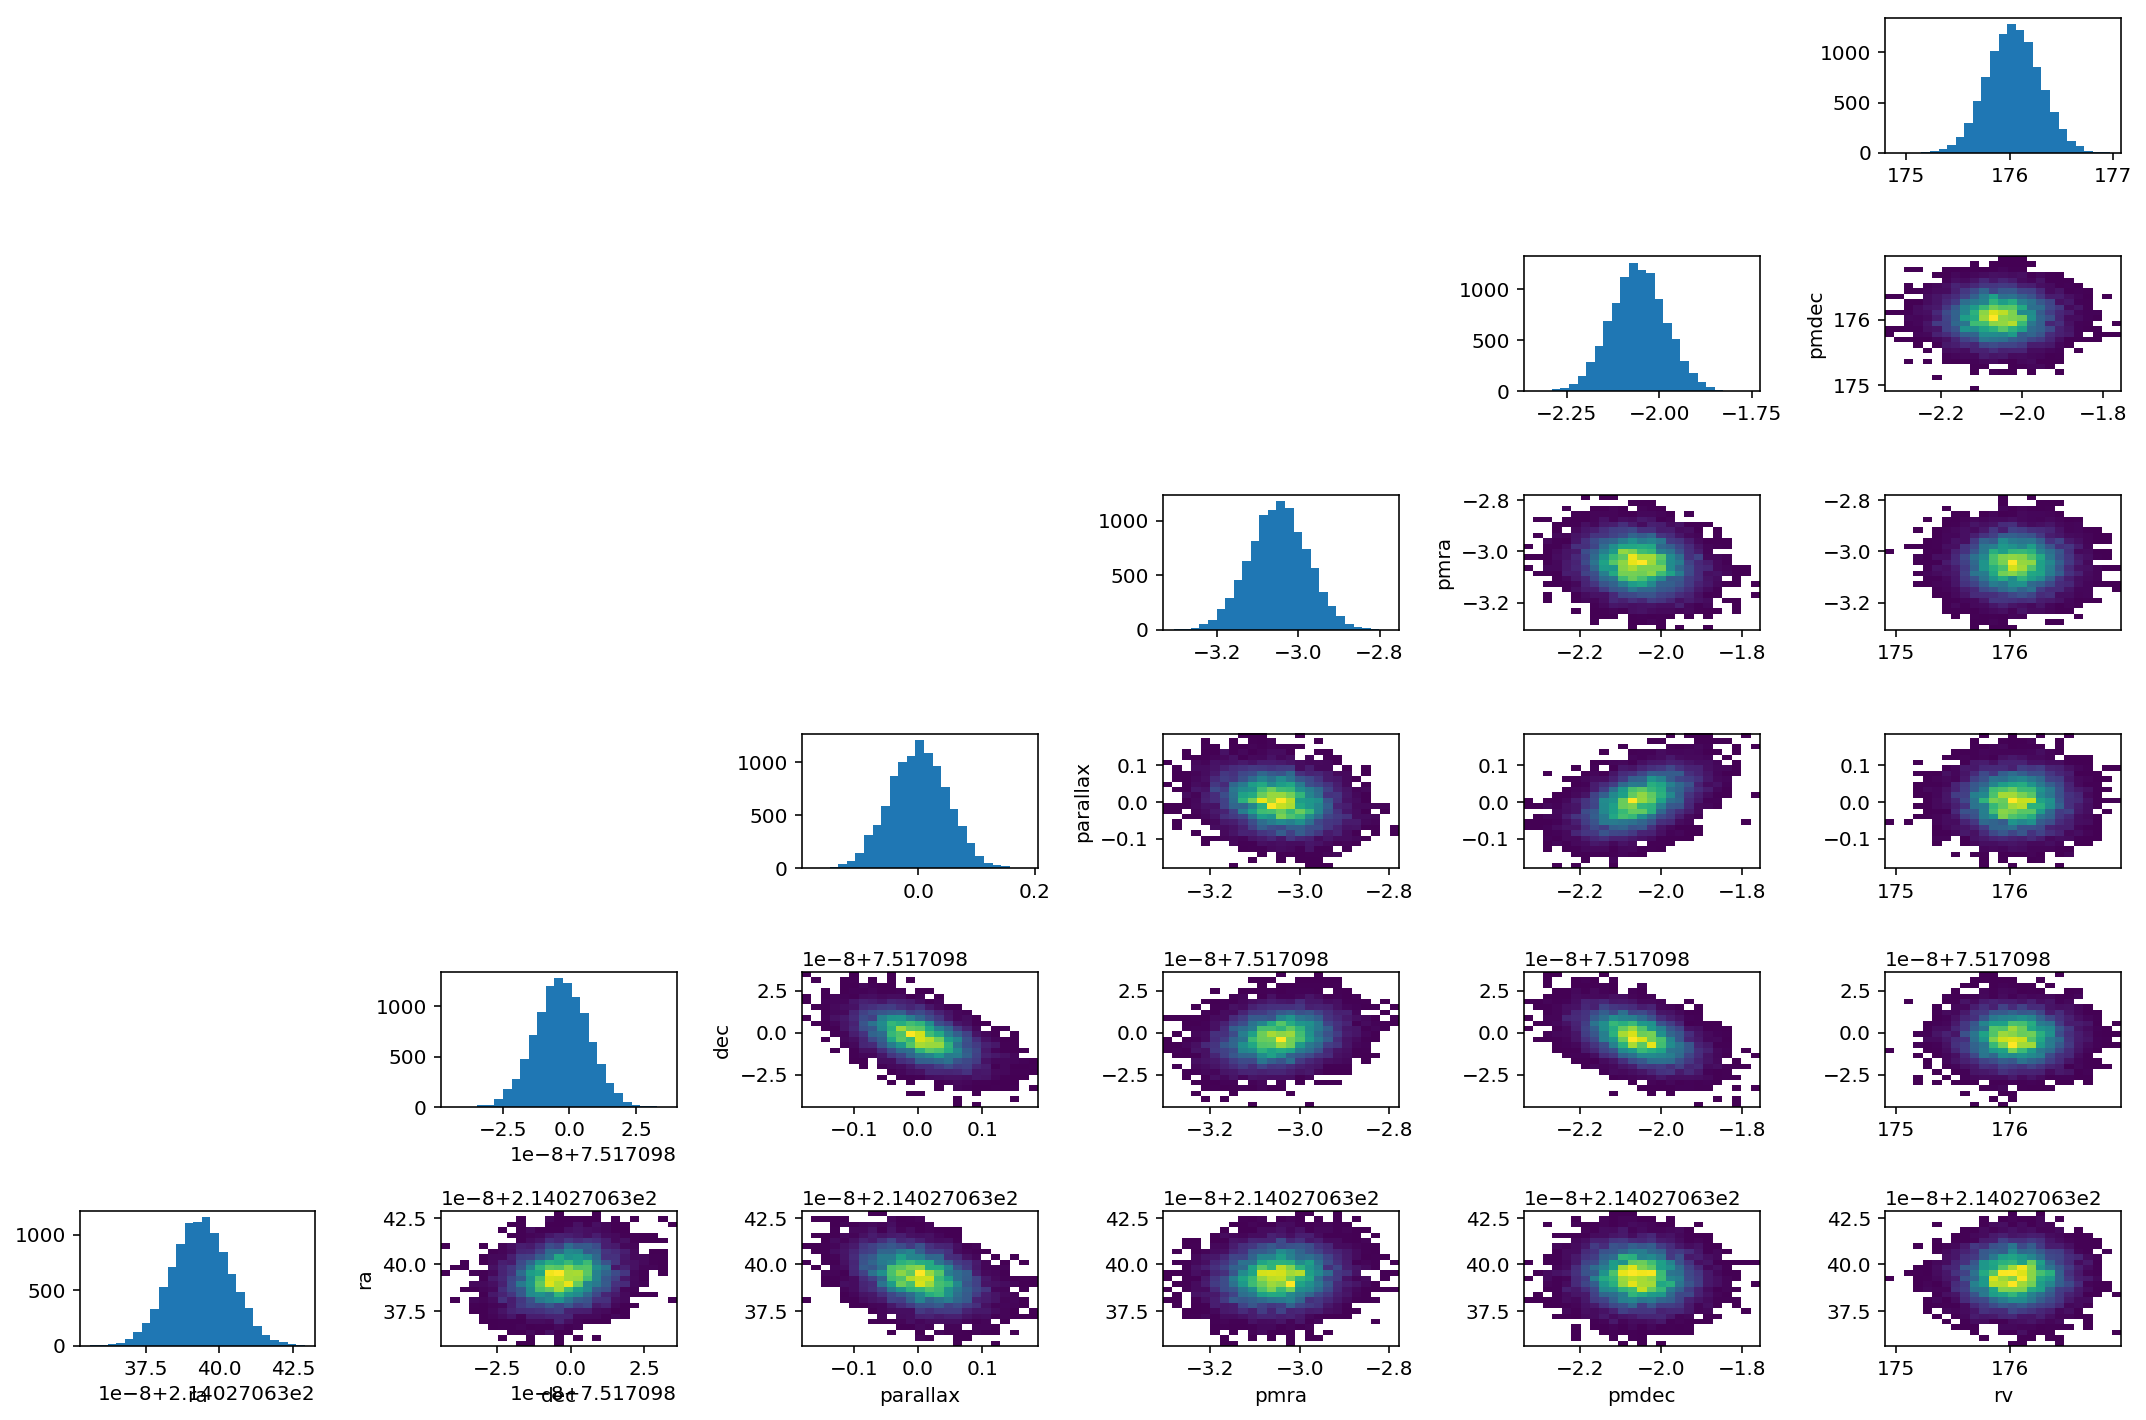

In [59]:
def plot_sampling(data):
    f = plt.figure(figsize=(15,10))

    hist_kwarfs=dict(bins=25,cmin=1)
    hist_k = dict(bins=25)
    
    ax=plt.subplot(6,6,31)
    ax.hist(y[0],**hist_k);
    ax.set_xlabel('ra')
    ax=plt.subplot(6,6,32)
    ax.hist2d(y[1],y[0],**hist_kwarfs);
    ax.set_ylabel('ra')
    ax.set_xlabel('dec')
    ax=plt.subplot(6,6,33)
    ax.hist2d(y[2],y[0],**hist_kwarfs);
    ax.set_xlabel('parallax')
    ax=plt.subplot(6,6,34)
    ax.hist2d(y[3],y[0],**hist_kwarfs);
    ax.set_xlabel('pmra')
    ax=plt.subplot(6,6,35)
    ax.hist2d(y[4],y[0],**hist_kwarfs);
    ax.set_xlabel('pmdec')
    ax=plt.subplot(6,6,36)
    ax.hist2d(y[5],y[0],**hist_kwarfs);
    ax.set_xlabel('rv')

    ax=plt.subplot(6,6,26)
    ax.hist(y[1],**hist_k);
    ax=plt.subplot(6,6,27)
    ax.set_ylabel('dec')
    ax.hist2d(y[2],y[1],**hist_kwarfs);
    ax=plt.subplot(6,6,28)
    ax.hist2d(y[3],y[1],**hist_kwarfs);
    ax=plt.subplot(6,6,29)
    ax.hist2d(y[4],y[1],**hist_kwarfs);
    ax=plt.subplot(6,6,30)
    ax.hist2d(y[5],y[1],**hist_kwarfs);

    ax=plt.subplot(6,6,21)
    ax.hist(y[2],**hist_k);
    ax=plt.subplot(6,6,22)
    ax.set_ylabel('parallax')
    ax.hist2d(y[3],y[2],**hist_kwarfs);
    ax=plt.subplot(6,6,23)
    ax.hist2d(y[4],y[2],**hist_kwarfs);
    ax=plt.subplot(6,6,24)
    ax.hist2d(y[5],y[2],**hist_kwarfs);

    ax=plt.subplot(6,6,16)
    ax.hist(y[3],**hist_k);
    ax=plt.subplot(6,6,17)
    ax.set_ylabel('pmra')
    ax.hist2d(y[4],y[3],**hist_kwarfs);
    ax=plt.subplot(6,6,18)
    ax.hist2d(y[5],y[3],**hist_kwarfs);

    ax=plt.subplot(6,6,11)
    ax.hist(y[4],**hist_k);
    ax=plt.subplot(6,6,12)
    ax.set_ylabel('pmdec')
    ax.hist2d(y[4],y[5],**hist_kwarfs);

    ax=plt.subplot(6,6,6)
    ax.hist(y[5],**hist_k);

    plt.tight_layout()

plot_sampling(uncertainty_6d)

In [ ]:
def distance_posterior(distance, parallax, parallax_error, r_len, parallax_zp = - 0.029):
    parallax /= 1000
    parallax_error /= 1000
    parallax_zp /= 1000
    if distance > 0:
        return(distance**2 * np.exp(-distance/r_len - 1/(2*parallax_error**2)*(parallax + parallax_zp - 1/distance)**2))
    else:
        return 0

In [ ]:
parallax_dist ---> samples{parallax} ---> 1/parallax = distance --> samples{1/parallax}
samples{1/parallax * distance_prior(1/parallax | Len)} === samples{Posterior(1/parallax)} === weighted sample

N samples how to map into Gamma distribution.... (the latter being the posterior form.)


Sample parallaxes and plug that into Galpy

But then weight action information with the help of the 1/parallax|Len prior!